In [1]:
import numpy as np
import pandas as pd

from pcntoolkit import BLRConf, NormConf, NormData
from pcntoolkit.normative_model.norm_factory import (
    create_normative_model,
    load_normative_model,
)

In [2]:
# First download the dataset from github
# fcon=pd.read_csv("https://raw.githubusercontent.com/pcn-toolkit/pcn-toolkit/master/resources/data/fcon1000.csv")
data = pd.read_csv("resources/data/fcon1000.csv")

In [3]:
data["sex "] = np.where(data["sex"] == 1, ["male"], ["female"])

In [4]:
# Group the data by site and sex
site_counts = data.groupby(["site", "sex"]).size().reset_index(name="counts")

# Get the sites with only one sex present
sex_count_per_site = site_counts["site"].value_counts()
sites_with_one_sex = sex_count_per_site[sex_count_per_site == 1]
sites_with_one_sex.index

# remove the sites with less than 10 samples
data = data[~data["site"].isin(sites_with_one_sex.index)]

# find the sites that have less than 10 samples
site_counts = site_counts[site_counts["counts"] < 10]

# remove the sites with less than 10 samples
data = data[~data["site"].isin(site_counts["site"])]

We find the seven largest sites, which we will use for train and transfer. Two of those are randomly selected for transfering later.

In [5]:
site_counts = data.groupby(["site"]).size().reset_index(name="counts")
site_counts = site_counts.sort_values("counts", ascending=False)
site_counts = site_counts.head(7)
display(site_counts)

np.random.seed(45)
# randomly select 2 sites from the top 7 sites for transfering
transfer_sites = site_counts.sample(2)["site"]
transfer_data = data[data["site"].isin(transfer_sites)]

# The remaining sites are used for training the model
fit_sites = site_counts[~site_counts.isin(transfer_sites)]["site"]
fit_sites.dropna(inplace=True)
fit_data = data[data["site"].isin(fit_sites)]

,site,counts
2,Beijing_Zang,198
4,Cambridge_Buckner,198
9,Oulu,102
6,ICBM,85
8,NewYork_a,83
7,Milwaukee_b,46
0,AnnArbor_b,32


Next, we load the data into `NormData` objects. All functions in the PCNtoolkit expect the data to be provided as instances of the `NormData` class. The class manages all preprocessing, basis expansions, and dimensions. 

In [6]:
covariates = ["age"]
batch_effects = ["sex", "site"]
response_vars = ["rh_MeanThickness_thickness", "WM-hypointensities"]

# Create a normdata object from the downloaded data
normdata = NormData.from_dataframe(
    name="fit",  # name of the dataset
    dataframe=fit_data,  # pandas dataframe
    covariates=covariates,
    batch_effects=batch_effects,
    response_vars=response_vars,
)

# Create a transfer data object from the downloaded data
transfer_data = NormData.from_dataframe(
    name="transfer",
    dataframe=transfer_data,
    covariates=covariates,
    batch_effects=batch_effects,
    response_vars=response_vars,
)

The NormData object has a number of useful attributes and functions, inherited from the `xarray.Dataset` class. A convenience function `select_batch_effects` is also available for quick filtering by site or sex(in this case). 

Splitting the data into train and test splits is also easy:

In [7]:
# Split data into training and test sets
# the splits are automatically stratified on the batch_effects
train, test = normdata.train_test_split(
    splits=[0.8, 0.2], split_names=["train", "test"]
)
transfer_train, transfer_test = transfer_data.train_test_split(
    splits=[0.8, 0.2], split_names=["transfer_train", "transfer_test"]
)

## Configure the normative model

The normative model will be configured using a `NormConf` object, containing save and log paths and the preprocessing configurations, and a `RegConf` object, specific to the regression model type. Our `NormConf` configuration contains canonical paths, a standardization step for both the input as as the output data, and a Bspline basis expansion.

In [8]:
# Create a NormConf object
norm_conf = NormConf(
    savemodel=True,
    save_dir="resources/save_dir",
    log_dir="resources/log_dir",
    inscaler="standardize",
    outscaler="standardize",
    basis_function="polynomial",
    order=3,
    nknots=5,
)

Configuration of normative model is valid.


## Configure the regression model


In [9]:
blr_conf = BLRConf(intercept=True, random_intercept=False)

Configuration of regression model is valid.


## Combine normative and hbr conf in normative model


In [10]:
# Using the factory method
norm_hbr = create_normative_model(norm_conf, blr_conf)
norm_hbr

## Fit the model

In [11]:
norm_hbr.fit(train)

Going to fit 2 models
Fitting model for rh_MeanThickness_thickness
Fitting model for WM-hypointensities


In [12]:
a = norm_hbr.regression_models["rh_MeanThickness_thickness"]
a.to_dict()

{'name': 'rh_MeanThickness_thickness',
 'reg_conf': {'n_iter': 300,
  'tol': 1e-05,
  'ard': False,
  'optimizer': 'l-bfgs-b',
  'l_bfgs_b_l': 0.1,
  'l_bfgs_b_epsilon': 0.1,
  'l_bfgs_b_norm': 'l2',
  'intercept': True,
  'heteroskedastic': False,
  'random_intercept': False,
  'random_var': False},
 'is_fitted': True,
 'is_from_dict': False,
 'hyp': [0.32585480761182345, 0.008326605590093301],
 'nlZ': 606.3283627220679,
 'N': 476,
 'D': 5,
 'lambda_n_vec': [1.3852142317089073,
  1.3852142317089073,
  1.3852142317089073,
  1.3852142317089073,
  1.3852142317089073,
  1.3852142317089073,
  1.3852142317089073,
  1.3852142317089073,
  1.3852142317089073,
  1.3852142317089073,
  1.3852142317089073,
  1.3852142317089073,
  1.3852142317089073,
  1.3852142317089073,
  1.3852142317089073,
  1.3852142317089073,
  1.3852142317089073,
  1.3852142317089073,
  1.3852142317089073,
  1.3852142317089073,
  1.3852142317089073,
  1.3852142317089073,
  1.3852142317089073,
  1.3852142317089073,
  1.385214

In [13]:
norm_hbr.current_regression_model

## Save the model

In [14]:
# The results are saved in the save_dir specified in the norm_conf
norm_hbr.save()

## Inspecting the model 

## Load the norm_hbr model from disk

In [15]:
norm_hbr = load_normative_model("resources/save_dir")

Configuration of normative model is valid.
Configuration of normative model is valid.
Configuration of regression model is valid.
Configuration of regression model is valid.
Configuration of regression model is valid.


In [16]:
norm_hbr.norm_conf.to_dict()

{'savemodel': True,
 'saveresults': False,
 'log_dir': 'resources/log_dir',
 'save_dir': 'resources/save_dir',
 'basis_function': 'polynomial',
 'basis_column': 0,
 'order': 3,
 'nknots': 5,
 'inscaler': 'standardize',
 'outscaler': 'standardize',
 'perform_cv': False,
 'cv_folds': 0,
 'normative_model_name': 'NormBLR'}

## Predict on the test set


In [17]:
norm_hbr.predict(test)

Going to predict 2 models
Predicting model for rh_MeanThickness_thickness
Predicting model for WM-hypointensities
Computing zscores for rh_MeanThickness_thickness
Computing zscores for WM-hypointensities
Computing centiles for rh_MeanThickness_thickness
Computing centiles for WM-hypointensities


/opt/anaconda3/envs/dev_refactor/lib/python3.12/site-packages/pcntoolkit/util/evaluator.py:203: RuntimeWarning: invalid value encountered in log
  nll = -np.mean(y * np.log(yhat) + (1 - y) * np.log(1 - yhat))


## Evaluation
Calling `predict` will extend the `NormData` object with a number of useful arrays.
1. `measures`: DataArray, which contains a number of evaluation statistics. 
1. `zscores`: the predicted z-scores for each datapoint.  
1. `centiles`: the predicted centiles of variation evaluated at each covariate in the dataset. 


In [18]:
display(test.measures.to_dataframe())

measures
response_vars              statistics            
rh_MeanThickness_thickness Rho           0.313604
                           RMSE          0.066557
                           SMSE          0.790369
                           ExpV          0.209644
                           NLL                NaN
                           ShapiroW      0.961160
WM-hypointensities         Rho           0.042647
                           RMSE        736.804938
                           SMSE          0.537074
                           ExpV          0.463267
                           NLL                NaN
                           ShapiroW      0.724288

Datasets with a zscores DataArray will have the `.plot_qq()` function available:

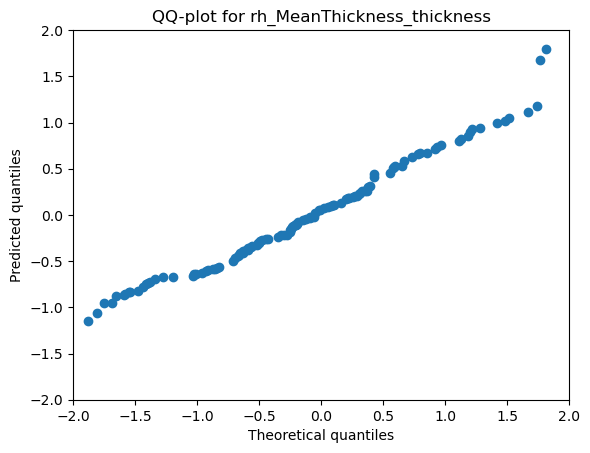

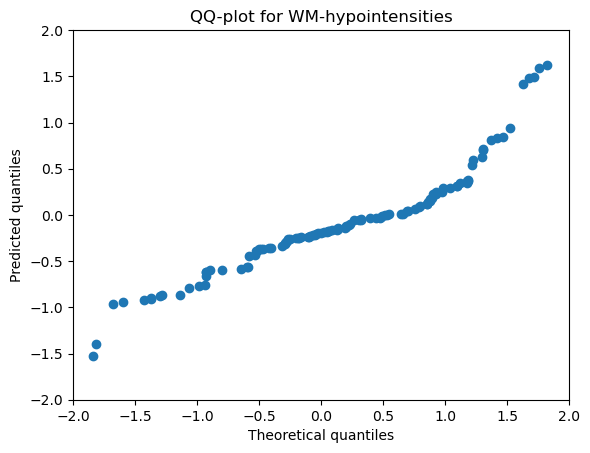

In [19]:
test.plot_qq(bound=2)  # Convenience function that plots the qq plot of the zscores

And `plot_centiles()` can be called as a function of the model. A synthetic dataset is created internally, so we need to pass the original dataset (`test` in this case) as a template. We also need to pass which covariate is to be plotted on the x-axis, and the batch-effects for which the centiles are to be plotted. 

The lines correspond to the CDF values of: [0.05, 0.1587, 0.25, 0.5, 0.75, 0.8413, 0.95]. 

The CDF values of 0.1587 and 0.8413 respectively correspond to a standard deviation of -1 and 1.


Computing centiles for rh_MeanThickness_thickness
Computing centiles for WM-hypointensities


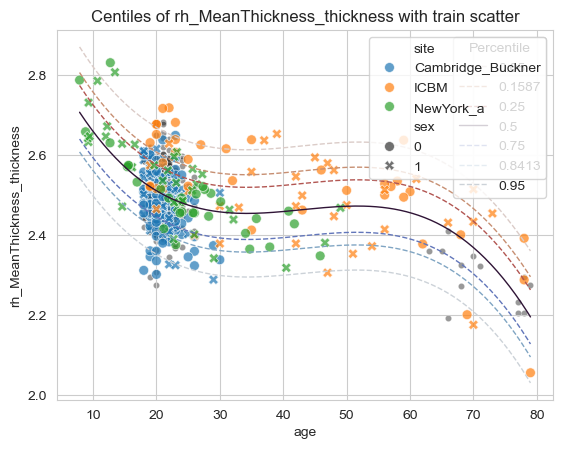

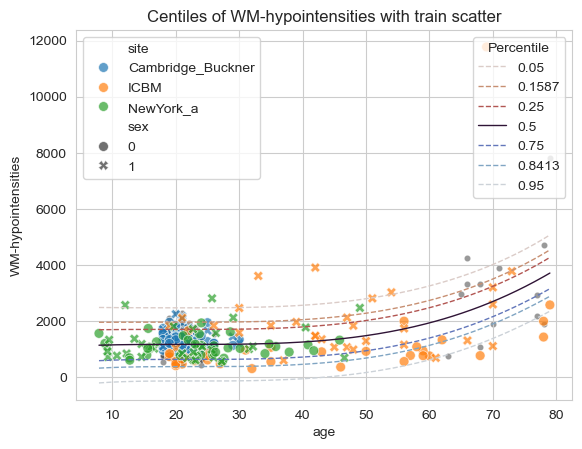

In [20]:
# test.centiles # the centiles
norm_hbr.plot_centiles(
    train,
    # cummul_densities=[0.05, 0.5, 0.95],
    covariate="age",
    batch_effects={"sex": [0, 1], "site": ["Cambridge_Buckner", "ICBM", "NewYork_a"]},
    show_data=True,
    plt_kwargs={"cmap": "twilight"},
)

In [22]:
test.to_dataframe()

X  scaled_X                  y                             \
                age       age WM-hypointensities rh_MeanThickness_thickness   
datapoints                                                                    
datapoint_101  26.0  0.013910              713.9                    2.49942   
datapoint_107  24.0 -0.137046              697.5                    2.51997   
datapoint_109  23.0 -0.212524             1049.5                    2.57632   
datapoint_112  20.0 -0.438958             1340.9                    2.48539   
datapoint_113  20.0 -0.438958             1081.3                    2.45487   
...             ...       ...                ...                        ...   
datapoint_86   20.0 -0.438958             1068.2                    2.52836   
datapoint_87   22.0 -0.288002              815.9                    2.43850   
datapoint_88   23.0 -0.212524             1025.7                    2.45818   
datapoint_9    21.0 -0.363480             1014.5                    2.50940   
datapoint_93   22.0 -0.288002              547.2                    2.43019   

                         zscores                             \
              WM-hypointensities rh_MeanThickness_thickness   
datapoints                                                    
datapoint_101          -0.613520                  -0.698361   
datapoint_107           0.089731                   0.201365   
datapoint_109          -0.449857                  -0.626151   
datapoint_112          -0.141834                  -0.105984   
datapoint_113          -0.356282                  -0.466077   
...                          ...                        ...   
datapoint_86           -0.182959                  -0.214325   
datapoint_87            1.968261                   1.801008   
datapoint_88           -0.058592                  -0.032368   
datapoint_9            -0.665837                  -0.734784   
datapoint_93            0.708995                   0.850498   

                        scaled_y                            batch_effects  \
              WM-hypointensities rh_MeanThickness_thickness           sex   
datapoints                                                                  
datapoint_101          -0.696657                   0.059162             0   
datapoint_107          -0.717238                   0.271637             1   
datapoint_109          -0.275506                   0.854264             1   
datapoint_112           0.090177                  -0.085900             0   
datapoint_113          -0.235600                  -0.401460             1   
...                          ...                        ...           ...   
datapoint_86           -0.252039                   0.358385             1   
datapoint_87           -0.568655                  -0.570717             0   
datapoint_88           -0.305373                  -0.367237             1   
datapoint_9            -0.319428                   0.162349             0   
datapoint_93           -0.905852                  -0.656637             0   

                             ...                           centiles  \
                       site  ... (rh_MeanThickness_thickness, 0.25)   
datapoints                   ...                                      
datapoint_101  Beijing_Zang  ...                           2.405447   
datapoint_107  Beijing_Zang  ...                           2.415733   
datapoint_109  Beijing_Zang  ...                           2.422035   
datapoint_112  Beijing_Zang  ...                           2.446063   
datapoint_113  Beijing_Zang  ...                           2.446063   
...                     ...  ...                                ...   
datapoint_86   Beijing_Zang  ...                           2.446063   
datapoint_87   Beijing_Zang  ...                           2.429164   
datapoint_88   Beijing_Zang  ...                           2.422035   
datapoint_9      AnnArbor_b  ...                           2.437160   
datapoint_93   Beijing_Zan

In [37]:
data = train.to_dataframe()
columns = [("X", "age"), ("y", "rh_MeanThickness_thickness")]
columns.extend([("batch_effects", be.item()) for be in train.batch_effect_dims])

data = data[columns]
data.columns = [c[1] for c in data.columns]
data

,age,rh_MeanThickness_thickness,sex,site
datapoints,,,,
datapoint_0,68.0,2.27184,0,AnnArbor_b
datapoint_1,19.0,2.59286,0,AnnArbor_b
datapoint_10,71.0,2.32356,1,AnnArbor_b
datapoint_100,20.0,2.49095,0,Beijing_Zang
datapoint_102,20.0,2.39858,0,Beijing_Zang
...,...,...,...,...
datapoint_95,21.0,2.45219,1,Beijing_Zang
datapoint_96,23.0,2.52746,0,Beijing_Zang
datapoint_97,20.0,2.49549,1,Beijing_Zang


In [34]:
train.batch_effect_dims

<xarray.DataArray 'batch_effect_dims' (batch_effect_dims: 2)> Size: 32B
array(['sex', 'site'], dtype='<U4')
Coordinates:
  * batch_effect_dims  (batch_effect_dims) <U4 32B 'sex' 'site'

In [34]:
train.batch_effects.to_dataframe().reset_index(drop=False).pivot(
    index="datapoints", columns="batch_effect_dims", values="batch_effects"
)

batch_effect_dims,sex,site
datapoints,,
datapoint_0,0,AnnArbor_b
datapoint_1,0,AnnArbor_b
datapoint_10,1,AnnArbor_b
datapoint_100,0,Beijing_Zang
datapoint_102,0,Beijing_Zang
...,...,...
datapoint_95,1,Beijing_Zang
datapoint_96,0,Beijing_Zang
datapoint_97,1,Beijing_Zang
